<a href="https://colab.research.google.com/github/s-pike3/Projects_In_AI-ML/blob/main/HW5_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

Projects in AI & ML HW5 Part 1 \\
Sarah Pike


Link to the dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [2]:
import numpy as np
from torch.utils.data.dataloader import default_collate
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import GridSearchCV
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.preprocessing import LabelBinarizer
!pip install torcheval
from torcheval.metrics import MulticlassAccuracy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.0 MB/s eta 0:00:00


### Setup

In [37]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [46]:
from torchvision import datasets, transforms

data_dir = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"
# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to a uniform size
    transforms.ToTensor()#,          # Convert images to tensors
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

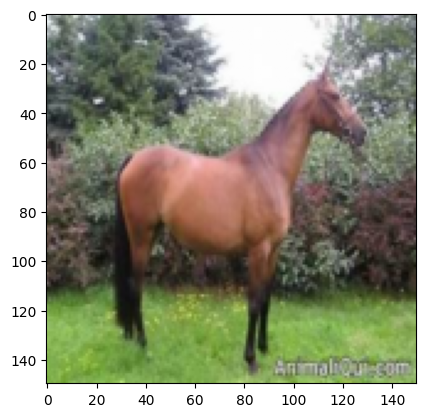

In [26]:
image_np = image.permute(1, 2, 0).numpy()

# Display the image using Matplotlib
plt.imshow(image_np)
plt.show()

Train-Val-Test Split

In [47]:
from torch.utils.data import random_split
generator1 = torch.Generator().manual_seed(42)
trainset,valset,testset = random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.1)+1,int(len(dataset)*0.1)+1], generator=generator1)

In [48]:
batch_size = 8

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)

#### CNN Model

In [8]:
# Adapted from https://medium.com/data-bistrot/a-simple-image-classifier-with-a-python-neural-network-82a5522fe48b
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [9]:
net = Net()
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Training method from https://medium.com/data-bistrot/a-simple-image-classifier-with-a-python-neural-network-82a5522fe48b
from tqdm import tqdm

EPOCHS = 15
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Save our trained model
PATH = './animals2.pth'
torch.save(net.state_dict(), PATH)

Training...


Epoch 15 of 15: 100%|███████████████████████| 2618/2618 [02:36<00:00, 16.69it/s]


Validation Performance

In [95]:
PATH = './animals2.pth'
from torch.utils.data import  default_collate
from torcheval.metrics import MulticlassAccuracy
model = Net()
model.load_state_dict(torch.load(PATH))
metric = MulticlassAccuracy()
X_val, y_val = default_collate(valset)
model.eval()
y_pred = model(X_val)
metric.update(y_pred, y_val)
metric.compute()

tensor(0.5882)

Test Performance

In [11]:
PATH = './animals2.pth'
from torch.utils.data import  default_collate
from torcheval.metrics import MulticlassAccuracy
model = Net()
model.load_state_dict(torch.load(PATH))
metric = MulticlassAccuracy()
X_val, y_val = default_collate(valset)
model.eval()
y_pred = model(X_val)
metric.update(y_pred, y_val)
metric.compute()

tensor(0.5882)

#### Data Augmentation

In [89]:
# Image Classification
from torch.utils.data import ConcatDataset
from torchvision.transforms import v2

H, W = 150, 150
img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)

aug_transforms = v2.Compose([
    transforms.Resize((150, 150)),  # Resize images to a uniform size
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=1),
    v2.ToTensor()
])
dataset = datasets.ImageFolder(data_dir, transform=aug_transforms)
aug_trainset,_,_ = random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.1)+1,int(len(dataset)*0.1)+1], generator=generator1)
aug_trainset_small,_ = random_split(aug_trainset, [int(len(aug_trainset)*0.33)-6,int(len(aug_trainset)*0.67)+7])
concat_dataset = ConcatDataset([trainset, aug_trainset_small])

In [87]:
net_aug = Net()
# Define a loss function and optimizer
criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [93]:
EPOCHS = 10
trainloader1 = torch.utils.data.DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader1, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data
        optimizer_aug.zero_grad()
        outputs = net_aug(inputs)
        loss = criterion_aug(outputs, labels)
        loss.backward()
        optimizer.step()

# Save our trained model
PATH = './animals_aug.pth'
torch.save(net_aug.state_dict(), PATH)

Training...


Epoch 10 of 10: 100%|███████████████████████| 3481/3481 [03:25<00:00, 16.96it/s]


Validation Performance

In [94]:
PATH = './animals_aug.pth'
from torch.utils.data import  default_collate
from torcheval.metrics import MulticlassAccuracy
model = Net()
model.load_state_dict(torch.load(PATH))
metric = MulticlassAccuracy()
X_val, y_val = default_collate(valset)
model.eval()
y_pred = model(X_val)
metric.update(y_pred, y_val)
metric.compute()

tensor(0.0554)

Test Performance

In [96]:
PATH = './animals_aug.pth'
from torch.utils.data import  default_collate
from torcheval.metrics import MulticlassAccuracy
model = Net()
model.load_state_dict(torch.load(PATH))
metric = MulticlassAccuracy()
X_val, y_val = default_collate(valset)
model.eval()
y_pred = model(X_val)
metric.update(y_pred, y_val)
metric.compute()

tensor(0.0554)

#### Discussion

Both validation and test accuracy are significantly lower when using data augmentation. It is possible that this is because the model is undertrained, and doing data augmentation may prevent overfitting if the model was fully trained.

### ResNet 50

In [97]:
from transformers import AutoImageProcessor, ResNetForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [98]:
label_dict = {"dog": 0, "horse": 1, "elephant":2, "butterfly": 3, "chicken":4, "cat": 5, "cow": 6, "sheep": 7, "spider":8}

In [103]:
data_dir = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size
    transforms.ToTensor()#,          # Convert images to tensors
])

# Load the dataset
dataset_res = datasets.ImageFolder(data_dir, transform=transform)

In [104]:
trainset_res,valset_res,testset_res = random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.1)+1,int(len(dataset)*0.1)+1], generator=generator1)

trainloader_res = torch.utils.data.DataLoader(trainset_res, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_res = torch.utils.data.DataLoader(trainset_res, batch_size=1, shuffle=True, num_workers=2)
testloader_res = torch.utils.data.DataLoader(trainset_res, batch_size=1, shuffle=True, num_workers=2)

In [106]:
score = 0
i = 0
for data in valloader_res:
    image, y = data

    inputs = processor(image.squeeze(), return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    # model predicts one of the 1000 ImageNet classes
    predicted_label = logits.argmax(-1).item()
    label = model.config.id2label[predicted_label]
    #print(label)
    if (label in label_dict) and (label_dict[label] == y):
      score = score + 1
    i = i + 1
    if (i == 500):
      break
score

0

ResNet50 does not identify any of the images correctly. It is thus significantly inferrior to the CNN model. Some hypotheses why ResNet performs so badly on this dataset are that the images may not be pre-processed correctly, or that the model may need additional training on this specific dataset.

Andrenacci, G. (2024, November 13). A simple image classifier with a python neural network. Medium. https://medium.com/data-bistrot/a-simple-image-classifier-with-a-python-neural-network-82a5522fe48b

Microsoft/resnet-50 · hugging face. microsoft/resnet-50 · Hugging Face. (n.d.). https://huggingface.co/microsoft/resnet-50

Tam, A. (2023, April 7). Training a PYTORCH model with DataLoader and Dataset. Machine Learning Mastery. https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/

Transforming and augmenting images. Transforming and augmenting images - Torchvision main documentation. (n.d.). https://pytorch.org/vision/main/transforms.html